# Pretraining `num_rows` vs transfered performance
Pretrain fastsim weights for 1M, 2M, 4M, 8M, ... rows

Then transfer and do fixed fullsim transfer training

In [1]:
import sys
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

from tqdm import tqdm
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import initializers

import wandb
from wandb.keras import WandbCallback

np.random.seed(8)
tf.random.set_seed(8)

physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)
tf.config.experimental.set_memory_growth(physical_devices[0], True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-04-27 21:29:48.289922: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2023-04-27 21:29:48.326063: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:41:00.0 name: NVIDIA A40 computeCapability: 8.6
coreClock: 1.74GHz coreCount: 84 deviceMemorySize: 44.56GiB deviceMemoryBandwidth: 648.29GiB/s
2023-04-27 21:29:48.327948: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2023-04-27 21:29:48.375134: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-04-27 21:29:48.413230: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2023-04-27 21:29:48.471222: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2023-0

In [2]:
train_file_names = os.listdir("/global/ml4hep/spss/mfong/transfer_learning/delphes_train")
for i in range(7, 15):
    train_file_names.remove(f"train_{i}.h5")
train_file_names
# f = h5py.File('/clusterfs/ml4hep/mfong/transfer_learning/delphes_train.h5', 'r')
# f2 = h5py.File('/clusterfs/ml4hep/mfong/transfer_learning/delphes_test.h5', 'r')

['train_5.h5',
 'train_0.h5',
 'train_4.h5',
 'train_1.h5',
 'train_6.h5',
 'train_2.h5',
 'train_3.h5']

In [3]:
num_samples_per_file = []
for train_file_name in train_file_names:
    f = h5py.File("/global/ml4hep/spss/mfong/transfer_learning/delphes_train/" + train_file_name, 'r')
    num_samples_per_file.append(f["fjet_clus_eta"].shape[0])
num_samples = sum(num_samples_per_file)
feature_keys = ['fjet_clus_eta', 'fjet_clus_phi', 'fjet_clus_pt']
num_features = 0
for k in feature_keys:
    num_features += f[k].shape[1]
x = np.empty((num_samples, num_features))

In [ ]:
current_row = 0
for train_file_name, current_num_samples in tqdm(zip(train_file_names, num_samples_per_file)):
    f = h5py.File("/global/ml4hep/spss/mfong/transfer_learning/delphes_train/" + train_file_name, 'r')
    x[current_row:current_row+current_num_samples] = np.concatenate([f[k] for k in feature_keys], axis=1)
    current_row += current_num_samples

0it [00:00, ?it/s]

In [ ]:
feature_keys = ['fjet_clus_eta', 'fjet_clus_phi', 'fjet_clus_pt']
for k in f.keys():
    print(k, f[k].shape)

In [ ]:
y = np.zeros((num_samples))
current_row = 0
for train_file_name, current_num_samples in tqdm(zip(train_file_names, num_samples_per_file)):
    f = h5py.File("/global/ml4hep/spss/mfong/transfer_learning/delphes_train/" + train_file_name, 'r')
    y[current_row:current_row+current_num_samples] = f["labels"][:]
    current_row += current_num_samples

In [ ]:
x.shape

In [ ]:
y.shape

In [ ]:
num_samples = len(y)
# num_train_samples = int(0.8 * num_samples)
num_train_samples = num_samples - 2000000       # save 2M rows for test data
x_train = x[:num_train_samples]
y_train = y[:num_train_samples]

x_test = x[num_train_samples:]
y_test = y[num_train_samples:]

In [ ]:
scaler = StandardScaler()
scaler.fit(x_train[:2000000])   # only use first 2M otherwise takes too long

x_train = scaler.transform(x_train, copy=False)
x_test = scaler.transform(x_test, copy=False)

In [ ]:
os.environ["WANDB_NOTEBOOK_NAME"] = "pretrain_MLP.ipynb"

In [ ]:
NUM_PRETRAIN_ROWS_LIST = [1000000, 2000000, 4000000, 8000000, 16000000, 32000000]
# config = wandb.config
# config.batch_size = 256
config = {
    "batch_size": 256,
    "epochs": 400,
}
for num_pretrain_rows in NUM_PRETRAIN_ROWS_LIST:
    # config.num_pretrain_rows = num_pretrain_rows
    config["num_pretrain_rows"] = num_pretrain_rows
    run = wandb.init(project="pretrain_MLP", name=f"fastsim_MLP_{int(num_pretrain_rows / 1000000)}M_rows", config=config, reinit=True)
    
    model = Sequential()
    model.add(Dense(64, input_shape=(600,), activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    history = model.fit(
        x_train[:config["num_pretrain_rows"]],
        y_train[:config["num_pretrain_rows"]],
        epochs=config["epochs"],
        batch_size=config["batch_size"],
        shuffle=True,
        validation_data=(x_test, y_test),
        callbacks=[wandb.keras.WandbCallback()]
    )
    
    plt.figure()
    plt.plot(history.history["accuracy"], label="acc")
    plt.plot(history.history["val_accuracy"], label="val_acc")
    plt.title(f"Fastsim MLP ({int(num_pretrain_rows / 1000000)}M Rows)")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend()
    plt.savefig(f"output/fastsim_MLP_{int(num_pretrain_rows / 1000000)}M_rows_acc.png")
    
    plt.figure()
    plt.plot(history.history["loss"], label="loss")
    plt.plot(history.history["val_loss"], label="val_loss")
    plt.title(f"Fastsim MLP ({int(num_pretrain_rows / 1000000)}M Rows)")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend()
    plt.savefig(f"output/fastsim_MLP_{int(num_pretrain_rows / 1000000)}M_rows_loss.png")
    
    
    
    model.save_weights(f"models/fastsim_MLP_{int(num_pretrain_rows / 1000000)}M_rows.h5")
    wandb.finish()

In [ ]:
# old stuff below

## Fully Connected NN

In [ ]:
model = Sequential()
model.add(Dense(64, input_shape=(600,), activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [133]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history = model.fit(x_train, y_train, epochs=800, batch_size=256, shuffle=True, validation_data=(x_test, y_test))

Epoch 1/1000
12501/12501 [==============================] - 35s 3ms/step - loss: 0.4352 - accuracy: 0.7934 - val_loss: 0.4302 - val_accuracy: 0.7964
Epoch 2/1000
12501/12501 [==============================] - 35s 3ms/step - loss: 0.4263 - accuracy: 0.7983 - val_loss: 0.4243 - val_accuracy: 0.8000
Epoch 3/1000
12501/12501 [==============================] - 33s 3ms/step - loss: 0.4227 - accuracy: 0.8004 - val_loss: 0.4210 - val_accuracy: 0.8017
Epoch 4/1000
12501/12501 [==============================] - 36s 3ms/step - loss: 0.4203 - accuracy: 0.8019 - val_loss: 0.4194 - val_accuracy: 0.8028
Epoch 5/1000
12501/12501 [==============================] - 36s 3ms/step - loss: 0.4189 - accuracy: 0.8028 - val_loss: 0.4184 - val_accuracy: 0.8032
Epoch 6/1000
12501/12501 [==============================] - 36s 3ms/step - loss: 0.4179 - accuracy: 0.8035 - val_loss: 0.4185 - val_accuracy: 0.8030
Epoch 7/1000
12501/12501 [==============================] - 36s 3ms/step - loss: 0.4171 - accuracy: 0.8040

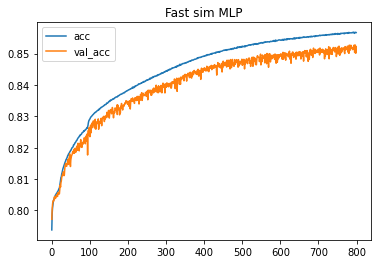

In [62]:
plt.plot(history.history["accuracy"], label="acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.title("Fast sim MLP")
plt.legend();

In [13]:
loss, accuracy = model.evaluate(x_test, y_test)
print("Accuracy: ", accuracy)
print("loss: ", loss)

25001/25001 [==============================] - 40s 2ms/step - loss: 0.3420 - accuracy: 0.8521
Accuracy:  0.8521325588226318
loss:  0.34203726053237915


In [ ]:
model.save_weights("fast_sim_MLP.h5")

# Full sim dataset

In [16]:
f_full_train = h5py.File("/global/ml4hep/spss/mfong/transfer_learning/train.h5", 'r')
f_full_test = h5py.File("/global/ml4hep/spss/mfong/transfer_learning/test.h5", 'r')

In [17]:
x_full = np.concatenate([f_full_train[k][:num_samples] for k in feature_keys], axis=1)
x_full.shape

(4000068, 600)

In [18]:
y_full = f_full_train["labels"][:num_samples]
y_full.shape

(4000068,)

In [19]:
x_full_train = x_full[:num_train_samples]
y_full_train = y_full[:num_train_samples]

x_full_test = x_full[num_train_samples:]
y_full_test = y_full[num_train_samples:]

In [20]:
scaler_full = StandardScaler()
scaler_full.fit(x_full_train)

x_full_train = scaler_full.transform(x_full_train)
x_full_test = scaler_full.transform(x_full_test)

## Full sim using all data for a long time

In [63]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
x_full_all_data = np.concatenate([f_full_train[k] for k in feature_keys], axis=1)
x_full_all_data.shape

In [74]:
y_full_all_data = f_full_train["labels"]
y_full_all_data.shape

(42233012,)

In [ ]:
num_samples_all_data = len(y_full_all_data)
num_train_samples_all_data = int(0.8 * num_samples_all_data)
print("num_samples_all_data:", num_samples_all_data)
print("num_train_samples_all_data:", num_train_samples_all_data)

x_full_train_all_data = x_full_all_data[:num_train_samples_all_data]
y_full_train_all_data = y_full_all_data[:num_train_samples_all_data]

x_full_test_all_data = x_full_all_data[num_train_samples_all_data:]
y_full_test_all_data = y_full_all_data[num_train_samples_all_data:]

In [ ]:
model_full_all_data = Sequential()
model_full_all_data.add(Dense(64, input_shape=(600,), activation='relu'))
model_full_all_data.add(Dense(8, activation='relu'))
model_full_all_data.add(Dense(1, activation='sigmoid'))

In [ ]:
model_full_all_data.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
filepath="full_sim_all_data_best_weights.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor="val_accuracy", verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

history_full_all_data = model_full_all_data.fit(
    x_full_train,
    y_full_train,
    epochs=2000,
    batch_size=256,
    shuffle=True,
    callbacks=callbacks_list,
    validation_data=(x_full_test, y_full_test))

In [ ]:
model_full_all_data.save_weights("full_sim_all_data_2000epochs_MLP.h5")

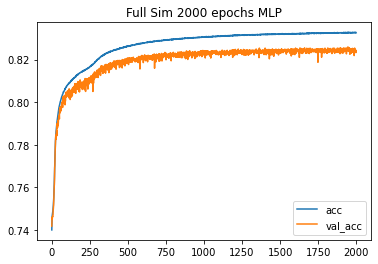

In [71]:
plt.plot(history_full_all_data.history["accuracy"], label="acc")
plt.plot(history_full_all_data.history["val_accuracy"], label="val_acc")
plt.title("Full Sim 2000 epochs MLP")
plt.legend();

## Fully Connected

In [21]:
model_full = Sequential()
model_full.add(Dense(64, input_shape=(600,), activation='relu'))
model_full.add(Dense(8, activation='relu'))
model_full.add(Dense(1, activation='sigmoid'))

In [22]:
model_full.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history_full = model_full.fit(x_full_train, y_full_train, epochs=800, batch_size=256, shuffle=True, validation_data=(x_full_test, y_full_test))

Epoch 1/800
12501/12501 [==============================] - 35s 3ms/step - loss: 0.5232 - accuracy: 0.7407 - val_loss: 0.5200 - val_accuracy: 0.7428
Epoch 2/800
12501/12501 [==============================] - 35s 3ms/step - loss: 0.5152 - accuracy: 0.7451 - val_loss: 0.5148 - val_accuracy: 0.7451
Epoch 3/800
12501/12501 [==============================] - 35s 3ms/step - loss: 0.5128 - accuracy: 0.7465 - val_loss: 0.5136 - val_accuracy: 0.7459
Epoch 4/800
12501/12501 [==============================] - 35s 3ms/step - loss: 0.5111 - accuracy: 0.7473 - val_loss: 0.5133 - val_accuracy: 0.7459
Epoch 5/800
12501/12501 [==============================] - 35s 3ms/step - loss: 0.5095 - accuracy: 0.7481 - val_loss: 0.5112 - val_accuracy: 0.7468
Epoch 6/800
12501/12501 [==============================] - 35s 3ms/step - loss: 0.5078 - accuracy: 0.7491 - val_loss: 0.5095 - val_accuracy: 0.7479
Epoch 7/800
12501/12501 [==============================] - 36s 3ms/step - loss: 0.5059 - accuracy: 0.7500 - val_

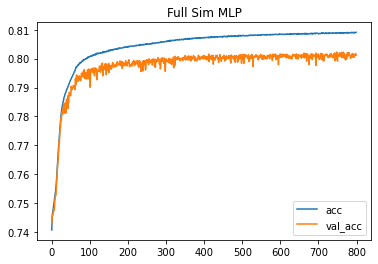

In [34]:
plt.plot(history_full.history["accuracy"], label="acc")
plt.plot(history_full.history["val_accuracy"], label="val_acc")
plt.title("Full Sim MLP")
plt.legend();

In [ ]:
model_full.save_weights("full_sim_MLP.h5")

## Use pretrained weights on full sim

In [ ]:
model_pretrained = Sequential()
model_pretrained.add(Dense(64, input_shape=(600,), activation='relu'))
model_pretrained.add(Dense(8, activation='relu'))
model_pretrained.add(Dense(1, activation='sigmoid'))

In [ ]:
model_pretrained.load_weights("fast_sim_MLP.h5")

In [ ]:
model_pretrained.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history_pretrained = model_pretrained.fit(x_full_train, y_full_train, epochs=800, batch_size=256, shuffle=True, validation_data=(x_full_test, y_full_test))

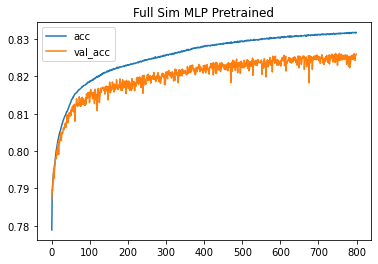

In [32]:
plt.plot(history_pretrained.history["accuracy"], label="acc")
plt.plot(history_pretrained.history["val_accuracy"], label="val_acc")
plt.title("Full Sim MLP Pretrained")
plt.legend();

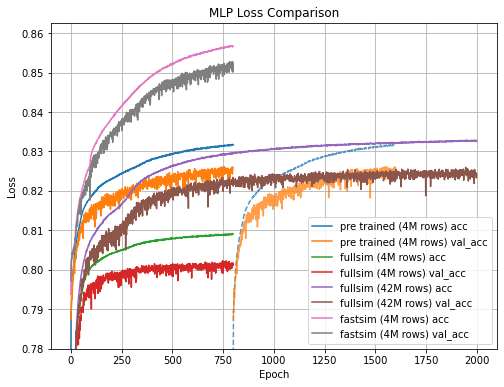

In [99]:
plt.figure(figsize=(8,6))

plt.plot(history_pretrained.history["accuracy"], label="pre trained (4M rows) acc")
plt.plot(history_pretrained.history["val_accuracy"], label="pre trained (4M rows) val_acc")
plt.plot(np.arange(800,1600), history_pretrained.history["accuracy"], "--", color="tab:blue", alpha=0.75)
plt.plot(np.arange(800,1600), history_pretrained.history["val_accuracy"], color="tab:orange", alpha=0.75)

plt.plot(history_full.history["accuracy"], label="fullsim (4M rows) acc")
plt.plot(history_full.history["val_accuracy"], label="fullsim (4M rows) val_acc")

plt.plot(history_full_all_data.history["accuracy"], label="fullsim (42M rows) acc")
plt.plot(history_full_all_data.history["val_accuracy"], label="fullsim (42M rows) val_acc")

plt.plot(history.history["accuracy"], label="fastsim (4M rows) acc")
plt.plot(history.history["val_accuracy"], label="fastsim (4M rows) val_acc")

plt.ylim(bottom=0.78)
plt.grid()
plt.title("MLP Loss Comparison")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend();

In [ ]:
# TODO

# email kevin this plot with some inital results
# use all fullsim and train fully from scratch


# pre train on full sim 4 mill - then take the next 4 mill train/validation

# try cos(phi) / sin(phi)
# try logE instead of E/pT, then standard scalar

In [41]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [40]:
# roc curve calcs
print("Fast sim")
y_pred_test = model.predict(x_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)
print("Full sim")
y_pred_test_full = model_full.predict(x_full_test)
fpr_full, tpr_full, thresholds_full = roc_curve(y_full_test, y_pred_test_full)
print("Full sim pretrained")
y_pred_test_pretrained = model_pretrained.predict(x_full_test)
fpr_pretrained, tpr_pretrained, thresholds_pretrained = roc_curve(y_full_test, y_pred_test_pretrained)

Fast sim
Full sim
Full sim pretrained


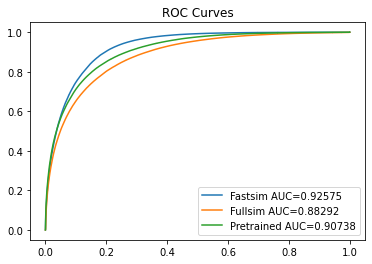

In [38]:
plt.plot(fpr, tpr, label="Fastsim AUC={0:.5f}".format(auc(fpr, tpr)))
plt.plot(fpr_full, tpr_full, label="Fullsim AUC={0:.5f}".format(auc(fpr_full, tpr_full)))
plt.plot(fpr_pretrained, tpr_pretrained, label="Pretrained AUC={0:.5f}".format(auc(fpr_pretrained, tpr_pretrained)))
plt.title("ROC Curves")
plt.legend();

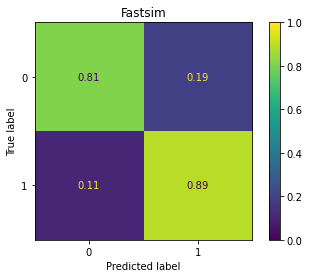

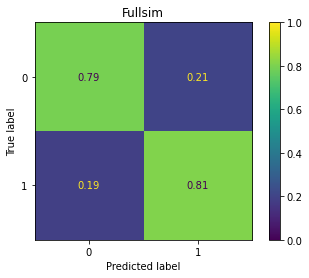

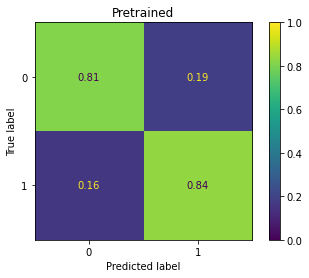

In [60]:
cm = confusion_matrix(y_test, (y_pred_test > 0.5), normalize="true")
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
disp.im_.set_clim(0, 1)
plt.title("Fastsim")
plt.show()

cm = confusion_matrix(y_full_test, (y_pred_test_full > 0.5), normalize="true")
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
disp.im_.set_clim(0, 1)
plt.title("Fullsim")
plt.show()

cm = confusion_matrix(y_full_test, (y_pred_test_pretrained > 0.5), normalize="true")
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
disp.im_.set_clim(0, 1)
plt.title("Pretrained")
plt.show()